# Example showcasing GEM access to weather/climate data

In this notebook we show how meteoblue weather data can be efficiently accessed using eo-learn to obtain weather data related to the 2022 Atlantic hurricane seasion.

We are going to have a look at windgust speeds of Atlantic Hurricane Ian which hit Florida on 28th of September 2022. Some general information about the Hurricane Season 2022 in the Atlantic can be found at the [National Hurricane Center](https://www.nhc.noaa.gov/data/tcr/index.php?season=2022&basin=atl).

From the resulting plots one will be clearly able to retrace the exact path of the hurricane and even see the eye of the tropical cyclone. Potentially, this weather data could be employed to determine the areas of maximum interest for a subsequent storm damage analysis using eo-data.

In [1]:
%matplotlib inline
import datetime

import matplotlib.pyplot as plt
from meteoblue import MeteoblueRasterTask, MeteoblueVectorTask

from eolearn.core import EOPatch, FeatureType
from sentinelhub import CRS, BBox, to_utm_bbox

In [2]:
# region of interest
ian_path_box = BBox(bbox=[-88, 15, -76, 35], crs=CRS.WGS84)
# time interval of interest
ian_time_interval = (datetime.datetime(2022, 9, 23), datetime.datetime(2022, 9, 30))
METEOBLUE_API_KEY = "<insert your meteoblue account API key here>"

## Retrieving ERA5T windgust speed 

The queries where configured using the [meteoblue dataset api configurator](https://www.meteoblue.com/en/weather/archive/dataquery).

### Add Weather Data as Vector Data Layer to EOPatch

In [3]:
query_vector = {
    "domain": "ERA5T",
    "gapFillDomain": None,
    "timeResolution": "daily",  # daily
    "codes": [
        {  # daily maximum of windgust at surface
            "code": 180,  # windgust
            "level": "sfc",  # at surface
            "aggregation": "max",  # aggregate to maximum
        }
    ],
    "transformations": [
        {  # aggregate all the daily time intervals to their maximum value ignoring missing values in the series
            "type": "aggregateTimeInterval",
            "aggregation": "maxIgnoreNaN",
        }
    ],
}

units = {
    "temperature": "C",
    "velocity": "km/h",
    "length": "metric",
    "energy": "watts",
}

In [4]:
eopatch_vectordata = EOPatch(bbox=ian_path_box)

feature = FeatureType.VECTOR, "WEATHER-DATA"
meteoblue_task = MeteoblueVectorTask(
    feature,
    METEOBLUE_API_KEY,
    query=query_vector,
    units=None,
)

eopatch_vectordata = meteoblue_task.execute(eopatch_vectordata, time_interval=ian_time_interval)

In [5]:
eopatch_vectordata

EOPatch(
  vector={
    WEATHER-DATA: geopandas.GeoDataFrame(columns=['TIMESTAMP', 'Longitude', 'Latitude', '180_sfc_maxIgnoreNaN', 'geometry'], length=3840, crs=EPSG:4326)
  }
  bbox=BBox(((-88.0, 15.0), (-76.0, 35.0)), crs=CRS('4326'))
)

<AxesSubplot: >

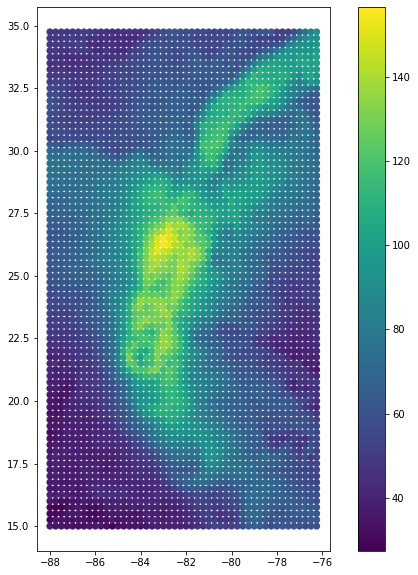

In [6]:
eopatch_vectordata.vector["WEATHER-DATA"].plot(column="180_sfc_maxIgnoreNaN", legend=True, figsize=(10, 10))

### Add Weather Data as Raster Data Layer to EOPatch

In [7]:
query_raster = {
    "domain": "ERA5T",
    "gapFillDomain": None,
    "timeResolution": "daily",  # daily
    "codes": [
        {  # daily maximum of windgust at surface
            "code": 180,  # windgust
            "level": "sfc",  # at surface
            "aggregation": "max",  # aggregate to maximum
        }
    ],
    "transformations": [
        {  # aggregate all the daily time intervals to their maximum value ignoring missing values in the series
            "type": "aggregateTimeInterval",
            "aggregation": "maxIgnoreNaN",
        },
        {  # resample to a utm grid, this is needed for a raster dataset
            # in order to have a guaranteed "rectangular" shape in the specified utm bbox/eopatch
            "type": "resampleToUtm",
            "zone": 17,
            "hemisphere": "northern",
            "xResolutionMeters": 15000,
            "yResolutionMeters": 15000,
            "interpolationMethod": "linear",
            "spatialAggregation": "mean",
            "disjointArea": "keep",
            "elevationDownscale": "disabled",
        },
    ],
}

In [8]:
eopatch = EOPatch(bbox=to_utm_bbox(ian_path_box))

weather_feature = FeatureType.DATA, "WEATHER-DATA"
meteoblue_task = MeteoblueRasterTask(weather_feature, METEOBLUE_API_KEY, query=query_raster, units=units)

eopatch = meteoblue_task.execute(eopatch, time_interval=ian_time_interval)

In [9]:
print(eopatch)
print(eopatch.data["WEATHER-DATA"][0].shape)

EOPatch(
  data={
    WEATHER-DATA: numpy.ndarray(shape=(1, 148, 81, 1), dtype=float64)
  }
  bbox=BBox(((-254189.17893640453, 1670293.3221448774), (956457.729273967, 3884483.9917153795)), crs=CRS('32617'))
  timestamp=[datetime.datetime(2022, 9, 23, 0, 0)]
)
(148, 81, 1)


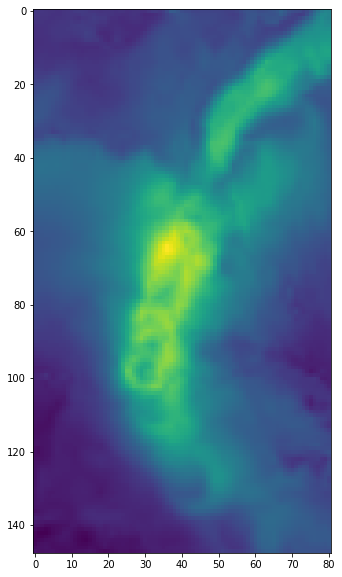

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(eopatch.data["WEATHER-DATA"][0].squeeze());